In [16]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, explained_variance_score, silhouette_score, accuracy_score, homogeneity_score, f1_score, roc_auc_score, classification_report, confusion_matrix

import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.random_projection import GaussianRandomProjection
from sklearn.model_selection import cross_val_score, validation_curve, GridSearchCV, train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import timeit

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


from util import evaluate_data, graph_LC, graph_C, normalize_data, create_stratified_data, prepare_data, preprocess_ufc_data

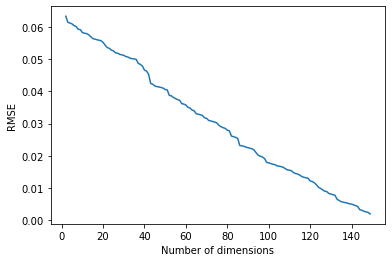

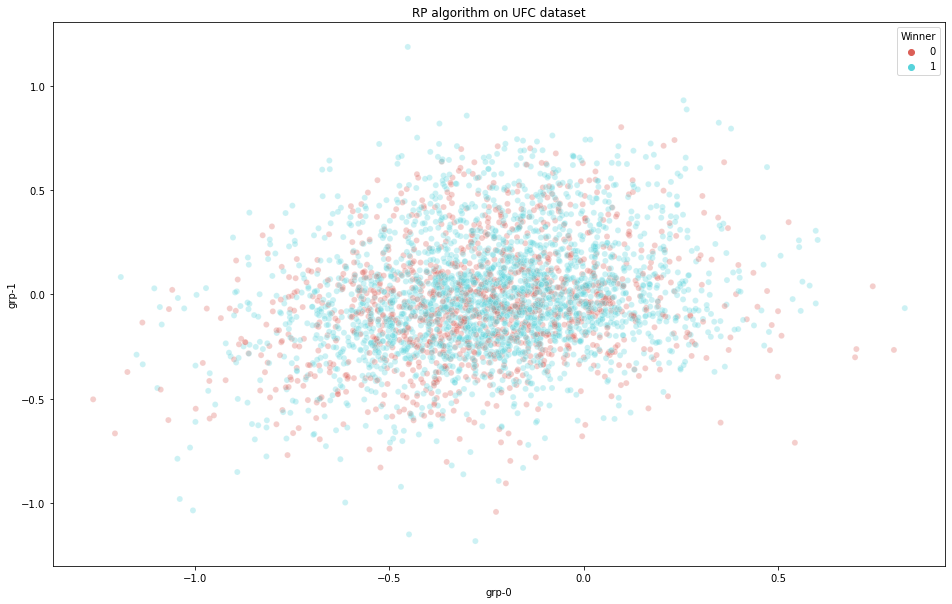

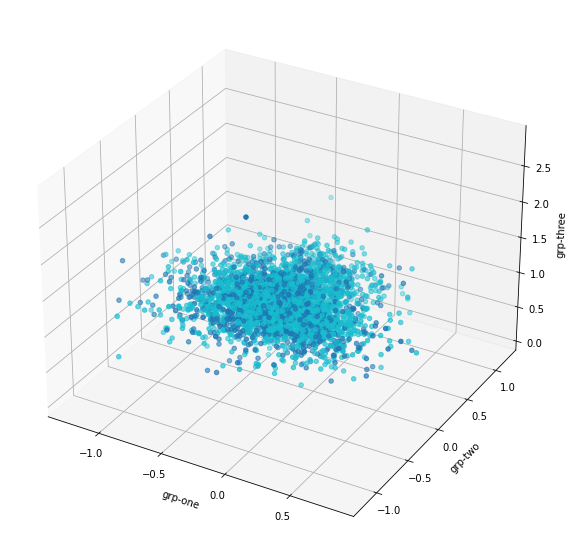

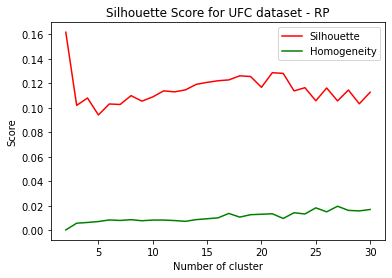

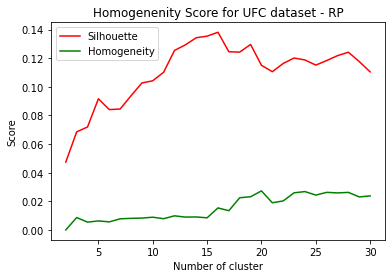

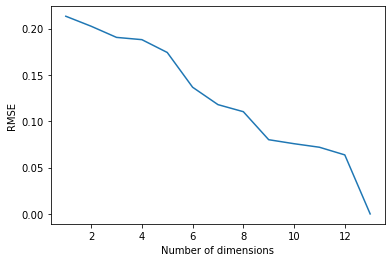

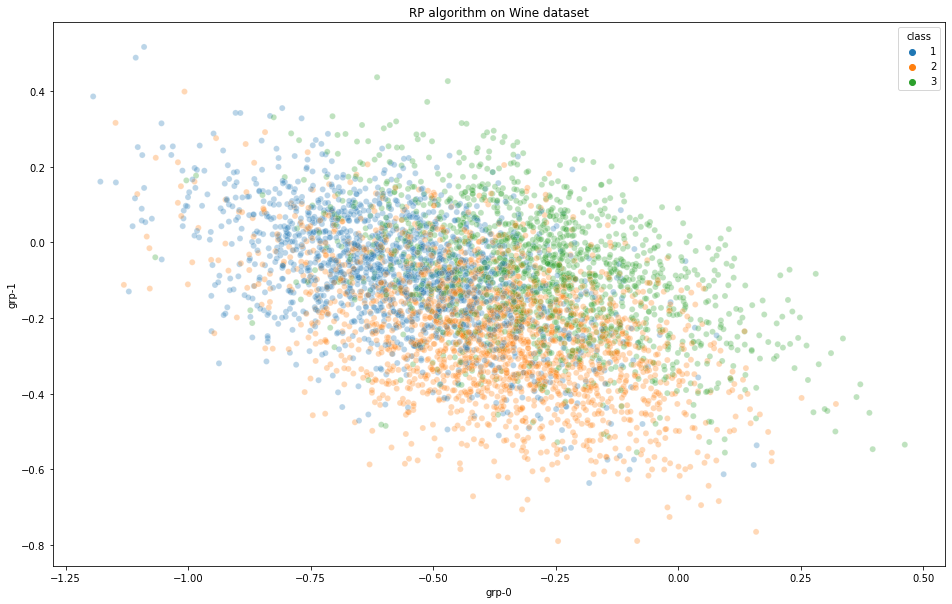

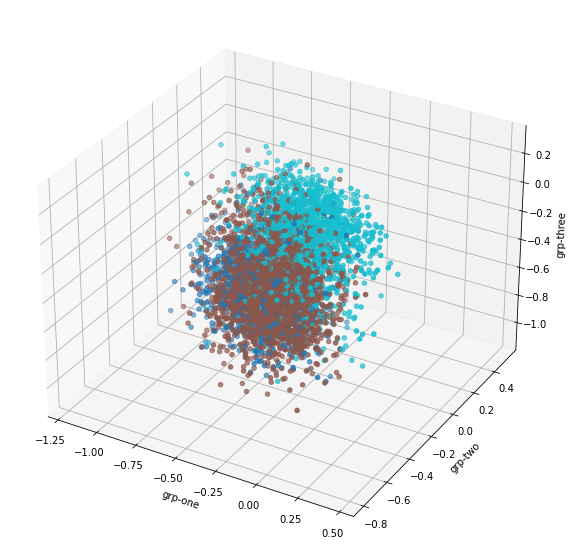

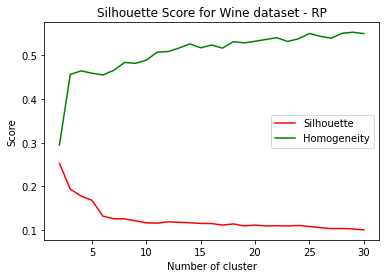

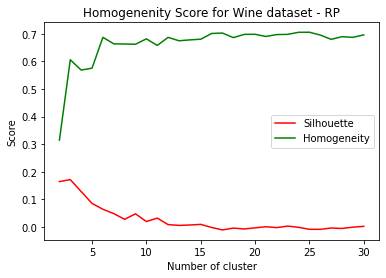

0.882
              precision    recall  f1-score   support

           1       0.92      0.90      0.91      1577
           2       0.86      0.90      0.88      2013
           3       0.88      0.83      0.85      1410

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000

[0.86785171 0.85412493 0.87180316 0.86807145 0.87403974 0.87177548
 0.88810655 0.87153843 0.86633142 0.87958135] 0.8713224227932159


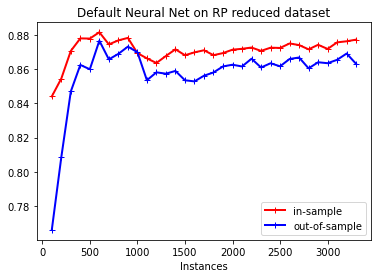

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    8.2s finished


[0.88029826 0.88117625 0.88130966] [0.86887563 0.86977544 0.86836856]


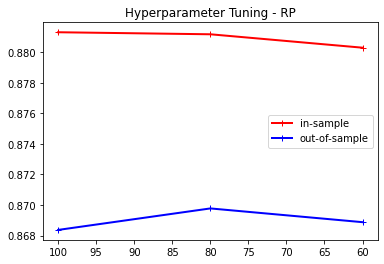

EM


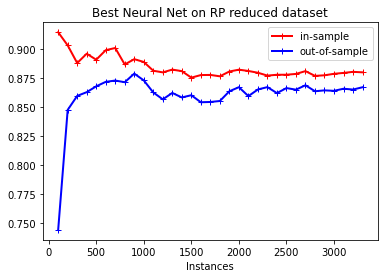

RP Time:  171.9518214869895
              precision    recall  f1-score   support

           1    0.91120   0.90595   0.90857       521
           2    0.88088   0.84639   0.86329       664
           3    0.81579   0.86667   0.84046       465

    accuracy                        0.87091      1650
   macro avg    0.86929   0.87300   0.87077      1650
weighted avg    0.87211   0.87091   0.87115      1650

[[472  25  24]
 [ 35 562  67]
 [ 11  51 403]]


In [17]:
def separate_data_label(dataset, label):
    X = dataset.drop(label, 1).copy().values
    Y = dataset[label].copy().values
    x_df = dataset.drop(label,1)
    
    return X, Y, x_df
    
def normalize(X, x_df):
    normalize_factor = preprocessing.MinMaxScaler()
    X = normalize_factor.fit_transform(X)
    x_df = pd.DataFrame(X, columns=x_df.columns)
    
    return X, x_df

def run_gridsearch(values, adaBoost, input_train_set, output_train_set, cross_validation_splitter, weighting):
    grid_suggestion = GridSearchCV(adaBoost, values, cv=cross_validation_splitter, scoring=weighting)
    grid_suggestion.fit(input_train_set, output_train_set)
    print(grid_suggestion.best_estimator_, grid_suggestion.best_score_)
    
    return grid_suggestion

def run_validation_curve(learner, input_train_set, output_train_set, hyperparameter_values, hyperparameter_values2, weighting, hyperparameter, inverse_x, cross_validation_splitter, title):
    result_train, result_test = validation_curve(
        learner, input_train_set, output_train_set, param_name=hyperparameter, param_range=hyperparameter_values,
        scoring=weighting, verbose=1, cv=cross_validation_splitter, n_jobs=-1
    )
    print(result_train.mean(axis=1), result_test.mean(axis=1))
    graph_C(result_train.mean(axis=1), result_test.mean(axis=1), hyperparameter_values2, title=title, inverse_x=inverse_x)
    
    return result_train, result_test

def compute_score(input_train_set, output_train_set, AdaBoost_Learner, mean, title):
    result = evaluate_data(input_train_set, output_train_set, AdaBoost_Learner, f1_score, average=mean)
    graph_LC(result[0], result[1], result[2], title=title)
    

def findOptimalNumFeatures(totalFeatures, x_df):
    aErrorOfRecontruction = {}
    for numFeatures in totalFeatures:
        cReducedAlgorithm = GaussianRandomProjection(n_components=numFeatures, random_state=44)
        NewLabels = cReducedAlgorithm.fit_transform(x_df.values)

        cMatrixInverse = np.linalg.pinv(cReducedAlgorithm.components_.T)
        newSpace = np.dot(NewLabels, cMatrixInverse)
        errorOfRecontruction = mean_squared_error(x_df.values, newSpace)    
        aErrorOfRecontruction[numFeatures] = errorOfRecontruction


    plt.figure()
    plt.plot(list(aErrorOfRecontruction.keys()), list(aErrorOfRecontruction.values()))
    plt.xlabel("Number of dimensions")
    plt.ylabel("RMSE")
    plt.show()

def RP_execution(x_df, comp, dataset):

    cReducedAlgorithm = GaussianRandomProjection(n_components=comp, random_state=44)
    optimalRP = cReducedAlgorithm.fit_transform(x_df.values)
    for i in range(comp):
        df_key = "grp-"+str(i)
        x_df[df_key] = optimalRP[:,i]
        dataset[df_key] = optimalRP[:,i]
    
    return optimalRP
    
    
def plot_RP(dataset, color_palette, num_colors, label, title):
    
    randomIndex = np.random.permutation(dataset.shape[0])
    
    plt.figure(figsize=(16,10))
    plt.title(title)
    sns.scatterplot(x = "grp-0", y = "grp-1", palette=sns.color_palette(color_palette, num_colors), hue=label,  legend="full", data=dataset, alpha=0.3)
    plt.savefig(title)
    plt.show()
    
    ax = plt.figure(figsize=(16,10)).gca(projection='3d')
    ax.scatter(xs=dataset.loc[randomIndex,:]["grp-0"], ys=dataset.loc[randomIndex,:]["grp-1"], zs=dataset.loc[randomIndex,:]["grp-2"], c=dataset.loc[randomIndex,:][label], cmap='tab10')
    ax.set_xlabel('grp-one')
    ax.set_ylabel('grp-two')
    ax.set_zlabel('grp-three')
    plt.savefig(title + " 3d")
    plt.show()
    
def plot_metric(dictSilohuetteScore, dictHomogeneityScore, yLabel, title):
    plt.figure()
    plt.title(title)
    plt.plot(list(dictSilohuetteScore.keys()), list(dictSilohuetteScore.values()), 'r', label="Silhouette")
    plt.plot(list(dictHomogeneityScore.keys()), list(dictHomogeneityScore.values()), 'g', label="Homogeneity")
    plt.legend()
    plt.xlabel("Number of cluster")
    plt.ylabel(yLabel)
    plt.savefig(title)
    plt.show()
    
def silh_homog_scores(numOfClusters, X, Y, isWine, title):
    dictSilohuetteScore = {}
    dictHomogeneityScore = {}
    for i in numOfClusters:
        cKMeansAlgorithm = KMeans(n_clusters=i, n_init=50, max_iter=1000, random_state=42).fit(X)
        if isWine:
            dictHomogeneityScore[i] = homogeneity_score(Y, (cKMeansAlgorithm.labels_+1))
        else:
            dictHomogeneityScore[i] = homogeneity_score(Y, cKMeansAlgorithm.labels_)
        dictSilohuetteScore[i] = silhouette_score(X, cKMeansAlgorithm.labels_, metric='euclidean')
        
    plot_metric(dictSilohuetteScore, dictHomogeneityScore, "Score", title)
    
def expectation_maximization(numOfClusters, X, Y, title):
    dictSilohuetteScore = {}
    dictHomogeneityScore = {}
    GaussianMixScore = {}
    for i in numOfClusters:
        cExpectationMaximization = GaussianMixture(n_components=i, max_iter=100, random_state=42).fit(X)
        target = cExpectationMaximization.predict(X)
        dictSilohuetteScore[i] = silhouette_score(X, target, metric='euclidean')
        dictHomogeneityScore[i] = homogeneity_score(Y, target)
        GaussianMixScore[i] = cExpectationMaximization.score(X)

    
    plot_metric(dictSilohuetteScore, dictHomogeneityScore, "Score", title)
    

if __name__ == "__main__":
    #Initialization
    wine_label = "class"
    ufc_label = "Winner"
    mean="weighted"
    cross_validation_splitter = 10
    weighting = 'f1_weighted'
    hyperparameter = "hidden_layer_sizes"
    np.random.seed(42)
    
    
    wine_dataset = pd.read_csv("wine_dataset.csv")
    ufc_dataset = pd.read_csv("ufc_data.csv")
    
    #Data preparation
    
    ufc_dataset = preprocess_ufc_data(ufc_dataset)
    
    wine_X, wine_Y, wine_x_df = separate_data_label(wine_dataset, wine_label)
    ufc_X, ufc_Y, ufc_x_df = separate_data_label(ufc_dataset, ufc_label)
    
    #Normalization
    
    wine_X, wine_x_df = normalize(wine_X, wine_x_df)
    ufc_X, ufc_x_df = normalize(ufc_X, ufc_x_df)
    
    
    
    #UFC
    
    comp = 40
    totalFeatures = list(range(2,150,1))
    
    findOptimalNumFeatures(totalFeatures, ufc_x_df)
    newLabelsUFC = RP_execution(ufc_x_df, comp, ufc_dataset)
    plot_RP(ufc_dataset, "hls", 2, ufc_label, "RP algorithm on UFC dataset")
    
    #Silhuette and homogenity scores
    
    silh_homog_scores(range(2, 31, 1), newLabelsUFC, ufc_Y, False, "Silhouette Score for UFC dataset - RP")
    
    
    #Expectation Maximization
    
    expectation_maximization(range(2, 31, 1), ufc_X, ufc_Y, "Homogenenity Score for UFC dataset - RP")
    
    
    #Wine
    
    comp = 9
    
    totalFeatures = list(range(1,14,1))
    
    findOptimalNumFeatures(totalFeatures, wine_x_df)
    newLabelsWine = RP_execution(wine_x_df, comp, wine_dataset)
    plot_RP(wine_dataset, "tab10", 3, wine_label, "RP algorithm on Wine dataset")
    
    #Silhuette and homogenity scores
    
    silh_homog_scores(range(2, 31, 1), newLabelsWine, wine_Y, True, "Silhouette Score for Wine dataset - RP")
    
    
    #Expectation Maximization
    
    expectation_maximization(range(2, 31, 1), wine_X, wine_Y, "Homogenenity Score for Wine dataset - RP")
    
    
    
    #Neural Net
    
    #KMeans

    NN_Learner = MLPClassifier()
    NN_Learner.fit(newLabelsWine, wine_Y)

    train_y_hat_wine = NN_Learner.predict(newLabelsWine)
    errorMetric = accuracy_score(wine_Y, train_y_hat_wine)
    print(errorMetric)
    print(classification_report(wine_Y, train_y_hat_wine))

    result = cross_val_score(NN_Learner, newLabelsWine, wine_Y, scoring="f1_weighted", cv=10)
    print(result, result.mean())

    input_train_set, input_test_set, output_train_set, output_test_set = train_test_split(newLabelsWine, wine_Y, test_size=0.33, random_state=42, stratify=wine_Y)

    compute_score(input_train_set, output_train_set, NN_Learner, mean, "Default Neural Net on RP reduced dataset")

    #Best net 

    optimized_NN = MLPClassifier(alpha=0.1, hidden_layer_sizes=(60, 60), learning_rate='invscaling')

    hyperparameter_values2 = [60, 80, 100]
    hyperparameter_values = [(60,60), (80,80), (100,100)]
    
    result_train, result_test = run_validation_curve(optimized_NN, input_train_set, output_train_set, hyperparameter_values, hyperparameter_values2, weighting, hyperparameter, True, 5, "Hyperparameter Tuning - RP")

    print('EM')
    start = timeit.default_timer()
    
    optimized_NN = MLPClassifier(alpha=0.1, hidden_layer_sizes=(60, 60), learning_rate='invscaling')
    
    compute_score(input_train_set, output_train_set, optimized_NN, mean, "Best Neural Net on RP reduced dataset")

    stop = timeit.default_timer()
    print('RP Time: ', stop - start) 
    
    optimized_NN.fit(input_train_set, output_train_set)
    test_y_hat = optimized_NN.predict(input_test_set)
    print(classification_report(output_test_set, test_y_hat, digits=5))
    print(confusion_matrix(output_test_set, test_y_hat))
    